In [1]:
import os
from datetime import datetime, timedelta
import string
from enum import Enum
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from test_case_utils import WeatherParams, TestCase, TargetCases, MlflowConfig
from geo_plot_utils import create_geo_plot, save_geo_plots, interpolate, TargetManilaErea, create_img_from_griddata

/home/akira/anaconda3/envs/poteka-pipeline-pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('seaborn-bright')
test_case_names = TargetCases.good_case_names + TargetCases.bad_case_names
run_ids = {
    'rainTempHumid': '7e8bb6ce24704ed3bf1b79912d9d8438',
    'rainonly': '5e8971a99ff84824bcc199d160cf5389'
}

In [3]:
test_case_name = TargetCases.bad_case_names[0]
data_paths = TestCase(test_case_name, run_id=run_ids['rainTempHumid']).data_pathes
print(test_case_name)

TC_case_2020-09-14_5-0_start


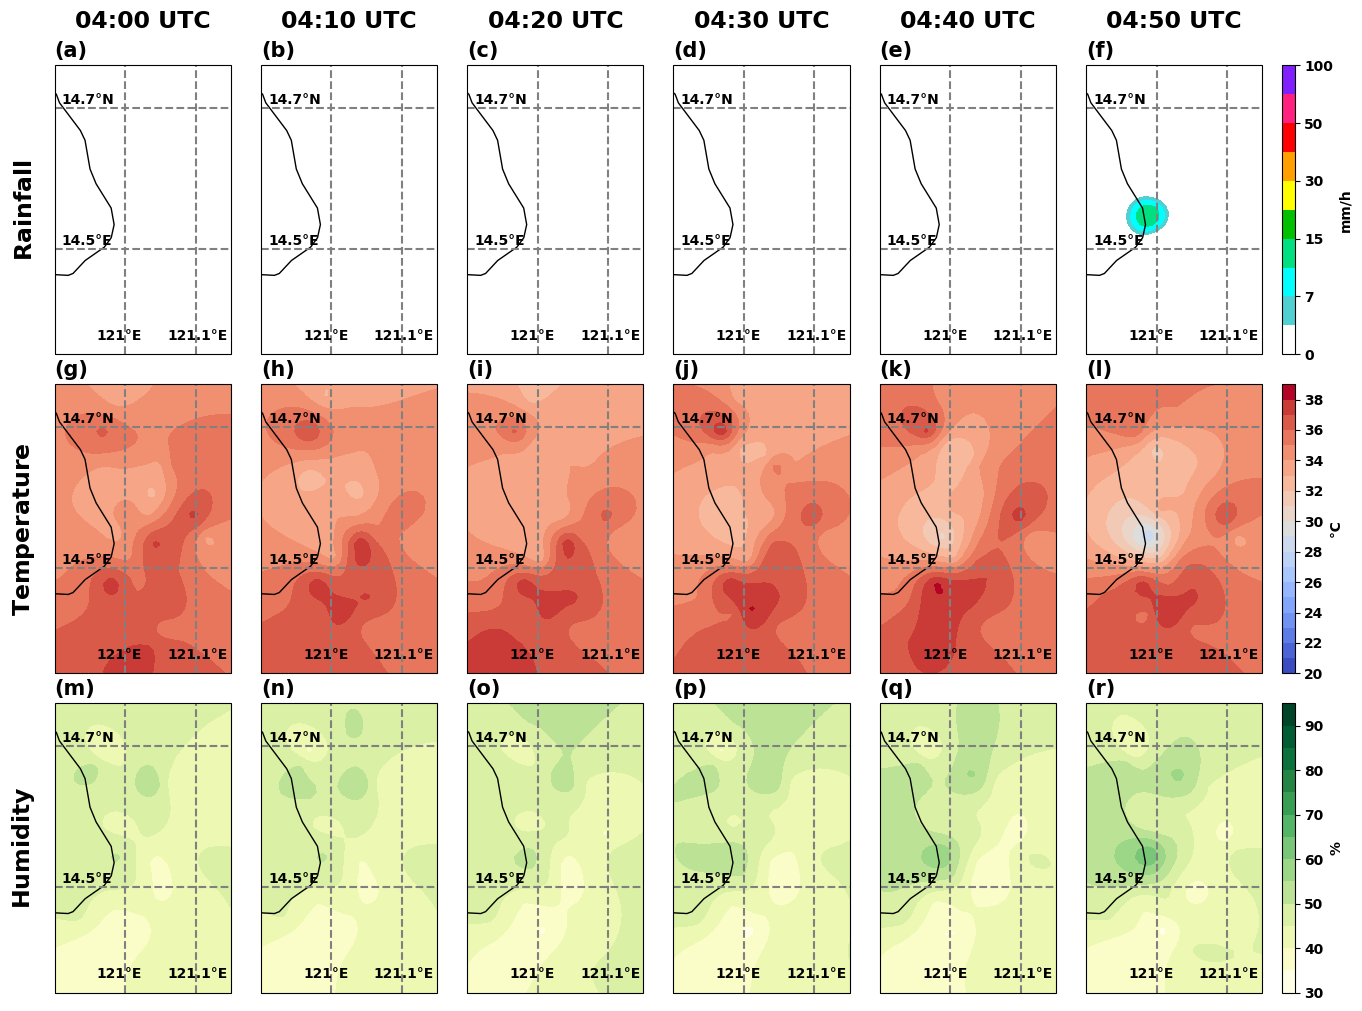

In [4]:
def set_plotarea(ax, projection) -> None:
    ax.set_extent(
        [
            TargetManilaErea.MIN_LONGITUDE,
            TargetManilaErea.MAX_LONGITUDE,
            TargetManilaErea.MIN_LATITUDE,
            TargetManilaErea.MAX_LATITUDE,
        ],
        crs=projection,
    )

def set_gridlines(ax, color='black') -> None:
    # x grid lines
    ax.axvline(x=121, color='gray', linestyle='--')
    ax.text(120.96, 14.37, '121°E', fontweight='bold', color=color)
    ax.axvline(x=121.1, color='gray', linestyle='--')
    ax.text(121.06, 14.37, '121.1°E', fontweight='bold', color=color)
    # y grid lines
    ax.axhline(y=14.7, color='gray', linestyle='--')
    ax.text(120.91, 14.705, '14.7°N', fontweight='bold', color=color)
    ax.axhline(y=14.5, color='gray', linestyle='--')
    ax.text(120.91, 14.505, '14.5°E', fontweight='bold', color=color)

def set_cbar(cbar_ax, cs, target_param, return_cbar = False):
    cbar = cbar_ax.colorbar(cs)
    for obj in cbar.ax.get_yticklabels():
        obj.set_fontweight('bold')
    cbar.set_label(label=WeatherParams.unit(target_param), weight='bold')
    if return_cbar:
        return cbar

def set_figlabel(ax, fig_idx):
    ax.set_title(f'({string.ascii_lowercase[fig_idx]})', loc='left', weight='bold', size=15)

def set_timelabel(ax, fig_idx, timelabels = ['7:40 UTC', '7:50 UTC','8:00 UTC','8:10 UTC','8:20 UTC','8:30 UTC']):
    ax.set_title(timelabels[fig_idx], loc='center', y=1.1, weight='bold', size=17)

def set_rowlabel(ax, idx, rowlabels = ["$\\bf{Rainfall}$", '$\\bf{Temperature}$', '$\\bf{Humidity}$']):
    ax.text(-0.1, 0.5, rowlabels[idx], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes, fontsize=17)


def plot_inputs(data_paths, target_params, ncols) -> None:
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes, dict(map_projection=projection))

    fig = plt.figure(figsize=(16, 24))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
        nrows_ncols=(len(target_params), ncols),
        axes_pad=0.3,
        cbar_location='right',
        cbar_mode='edge',
        cbar_pad=0.2,
        cbar_size='7%',
        label_mode='')
    for i, ax in enumerate(axgr):
        target_param = target_params[i // ncols]
        set_figlabel(ax, i)
        set_plotarea(ax, projection)
        set_gridlines(ax)

        if i // ncols == 0:
            # Rainfall
            data = pd.read_csv(data_paths[WeatherParams.rainfall]['input'][i % ncols], index_col=0).to_numpy()
        else:
            # Tempearture and Humidity
            data = interpolate(
                pd.read_csv(data_paths['one_day_data']['input'][i - (i // ncols) * ncols]).rename(columns={'Unnamed: 0': 'Station_Name'}),
                param_name=target_param,
            )
        cs = create_img_from_griddata(
            ax, data, WeatherParams.get_clevels(target_param) if target_param != WeatherParams.attention_map else WeatherParams.get_clevels(target_param, data.max()),
            WeatherParams.get_cmap(target_param),
            # contour=False if target_param in [WeatherParams.rainfall, WeatherParams.attention_map] else True,
            contour=False,
        )
        
        ax.coastlines()
        if i % ncols ==  0:
            set_cbar(axgr.cbar_axes[i // ncols], cs, target_param)
            set_rowlabel(ax, i // ncols)
        if i // ncols == 0:
            set_timelabel(ax, i, ['04:00 UTC', '04:10 UTC','04:20 UTC','04:30 UTC','04:40 UTC','04:50 UTC'])
    plt.savefig('2020-09-14-case-inputs.eps', format='eps', bbox_inches='tight')
    # plt.savefig('2019-10-12-case-inputs.png')
plot_inputs(data_paths, [WeatherParams.rainfall, WeatherParams.temperature, WeatherParams.humidity], 6)
plt.show()
plt.close()

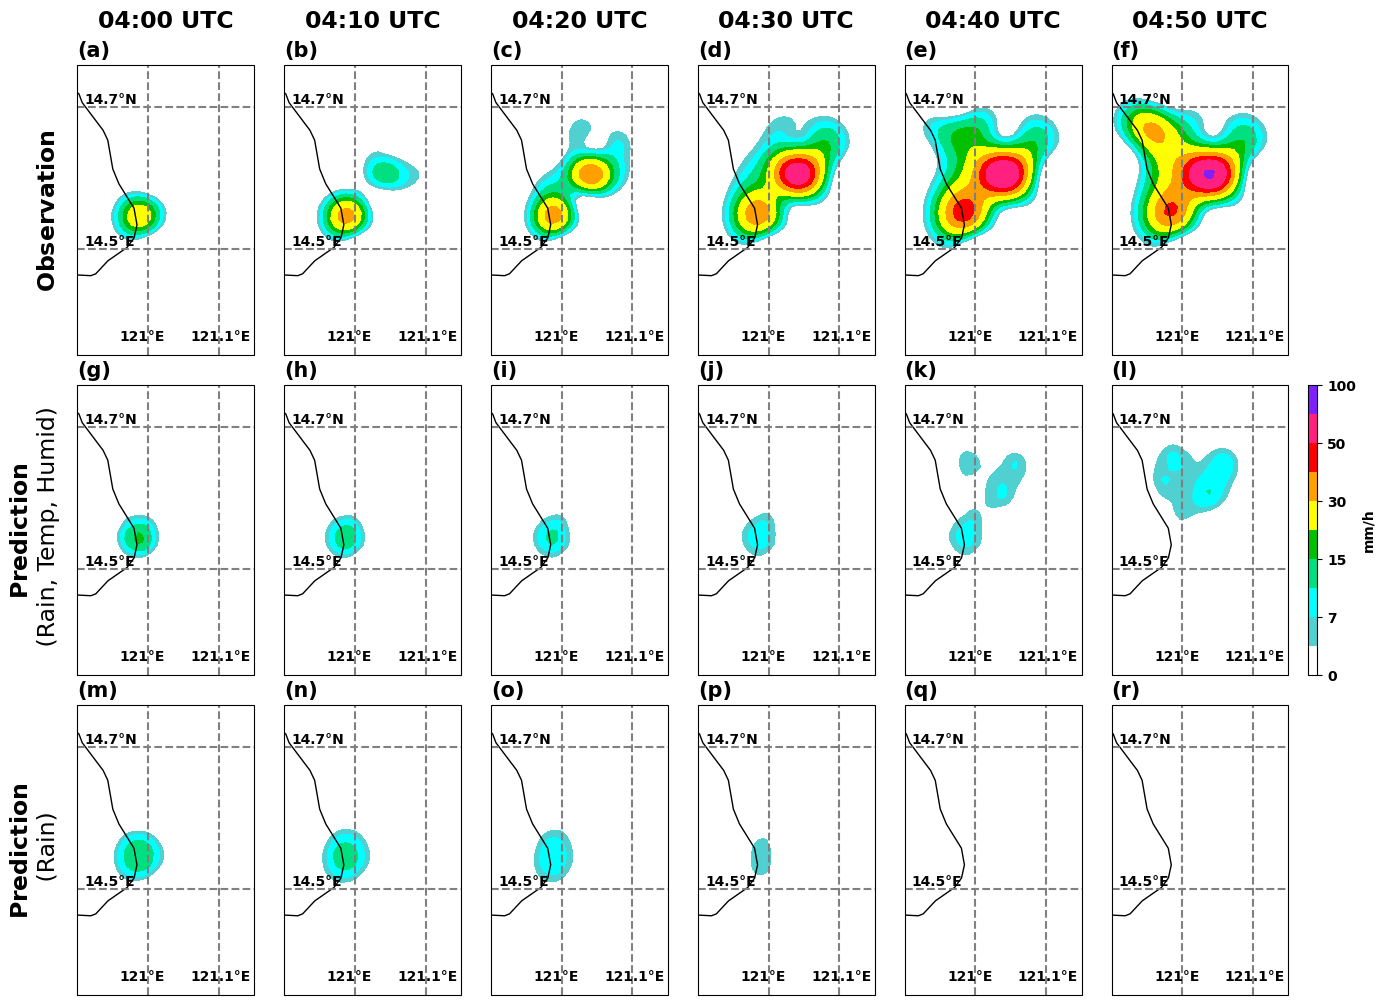

In [5]:
def plot_predicts(ncols):
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes, dict(map_projection=projection))

    fig = plt.figure(figsize=(16, 24))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
        nrows_ncols=(3, ncols),
        axes_pad=0.3,
        cbar_location='right',
        cbar_mode='edge',
        cbar_pad=0.2,
        cbar_size='5%',
        label_mode='')

    # Observation, best model, worst model
    for i, ax in enumerate(axgr):
        set_figlabel(ax, i)
        set_plotarea(ax, projection)
        set_gridlines(ax)

        if i // ncols == 0:
            data_paths = TestCase(test_case_name).data_pathes
            data = pd.read_csv(data_paths[WeatherParams.rainfall]['label'][i % ncols], index_col=0).to_numpy()
        elif i // ncols == 1:
            data_paths = TestCase(test_case_name, run_id=run_ids['rainTempHumid']).data_pathes
            data = pd.read_parquet(data_paths[WeatherParams.rainfall]['predict'][i % ncols]).to_numpy()
        else:
            data_paths = TestCase(test_case_name, run_id=run_ids['rainonly']).data_pathes
            data = pd.read_parquet(data_paths[WeatherParams.rainfall]['predict'][i % ncols]).to_numpy()
        
        cs = create_img_from_griddata(
            ax, data, WeatherParams.get_clevels(WeatherParams.rainfall),
            WeatherParams.get_cmap(WeatherParams.rainfall),
            # contour=False if target_param in [WeatherParams.rainfall, WeatherParams.attention_map] else True,
            contour=False,
        )
        ax.coastlines()
        if i % ncols == 0 and i // ncols == 1:
            set_cbar(axgr.cbar_axes[i // ncols], cs, WeatherParams.rainfall)

        if i % ncols ==  0:
            set_rowlabel(ax, i // ncols, rowlabels=['$\\bf{Observation}$', '$\\bf{Prediction}$\n (Rain, Temp, Humid)', '$\\bf{Prediction}$\n (Rain)'])
            cbar = set_cbar(axgr.cbar_axes[i // ncols], cs, WeatherParams.rainfall, return_cbar=True)
            if i // ncols != 1:
                cbar.remove()
        if i // ncols == 0:
            set_timelabel(ax, i, ['04:00 UTC', '04:10 UTC', '04:20 UTC', '04:30 UTC', '04:40 UTC', '04:50 UTC'])
    plt.savefig('2020-09-14-case-predictions.eps', format='eps', bbox_inches='tight')
        

plot_predicts(ncols=6)
plt.show()
plt.close()

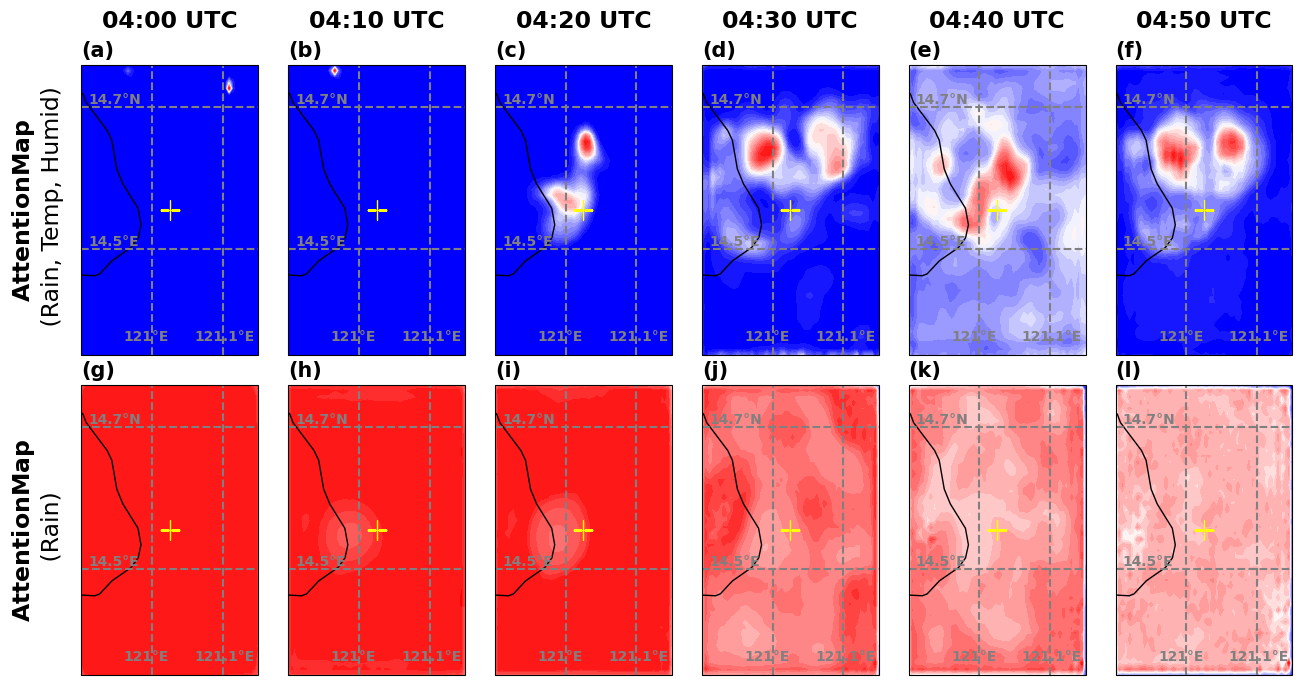

In [6]:
def plot_attentionmaps(ncols):
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes, dict(map_projection=projection))

    fig = plt.figure(figsize=(16, 24))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
        nrows_ncols=(2, ncols),
        axes_pad=0.3,
        cbar_location='right',
        cbar_mode='edge',
        cbar_pad=0.2,
        cbar_size='5%',
        label_mode='')

    # best model, worst model
    target_layer = 4
    for i, ax in enumerate(axgr):
        set_figlabel(ax, i)
        set_plotarea(ax, projection)
        set_gridlines(ax, color='gray')

        if i // ncols == 0:
            data_paths = TestCase(test_case_name, run_id=run_ids['rainTempHumid']).data_pathes
        else:
            data_paths = TestCase(test_case_name, run_id=run_ids['rainonly']).data_pathes

        data = np.load(data_paths['attention_maps'][f'layer{target_layer}'][i % ncols])
        
        cs = create_img_from_griddata(
            ax, data, WeatherParams.get_clevels(WeatherParams.attention_map, data.max()),
            WeatherParams.get_cmap(WeatherParams.attention_map),
            # contour=False if target_param in [WeatherParams.rainfall, WeatherParams.attention_map] else True,
            contour=False,
        )
        # Plot query position
        x_center = (
        TargetManilaErea.MIN_LONGITUDE + (TargetManilaErea.MAX_LONGITUDE - TargetManilaErea.MIN_LONGITUDE) / 2
        )
        y_center = TargetManilaErea.MIN_LATITUDE + (TargetManilaErea.MAX_LATITUDE - TargetManilaErea.MIN_LATITUDE) / 2
        ax.plot(x_center, y_center, color="yellow", marker="+", markersize=15)
        # Plot coastlines
        ax.coastlines()
        # Cbar values info
        # cbar = set_cbar(axgr.cbar_axes[i], cs, WeatherParams.attention_map, return_cbar=True)
        # cbar.ax.ticklabel_format(style="sci", scilimits=(-3, -3), useMathText=True)
        # offset_text = cbar.ax.yaxis.get_offset_text()
        # offset_text.set_fontsize(15)
        # offset_text.set_fontweight('bold')


        if i % ncols ==  0:
            set_rowlabel(ax, i // ncols, rowlabels=['$\\bf{Attention Map}$\n (Rain, Temp, Humid)', '$\\bf{Attention Map}$\n (Rain)'])
            cbar = set_cbar(axgr.cbar_axes[i // ncols], cs, WeatherParams.rainfall, return_cbar=True)
            cbar.remove()
        if i // ncols == 0:
            set_timelabel(ax, i, ['04:00 UTC', '04:10 UTC','04:20 UTC','04:30 UTC','04:40 UTC','04:50 UTC'])
    plt.savefig('2020-09-14-case-attentionmaps.eps', format='eps', bbox_inches='tight')
        

plot_attentionmaps(ncols=6)
plt.show()
plt.close()